# BN Generation Parameter Sweep

This notebook sweeps over DAG/BN generation parameters outlined in `notebooks/graph_generation/ideas.md` and materializes multiple discrete BN variants per DAG.

It varies:
- n (number of variables)
- target treewidth
- variable arity (fixed or range)
- CPT skewness (Dirichlet alpha)
- determinism fraction (mostly 0%)

Outputs:
- CSV with per-variant metadata
- On-screen CPT previews for a small sample



In [62]:
import sys
from pathlib import Path
import re
from os import getenv

# Ensure src is importable
repo_root = Path(".").resolve().parents[1]
sys.path.append(str(repo_root / 'src'))

from graph_generation import generate_dag_with_treewidth
from bn_generation import generate_variants_for_dag
from cpd_utils import cpd_to_ascii_table
from discrete.discrete_inference import format_probability_query, query_probability
from llm_calling import run_llm_call
from yaml_utils import load_yaml

import pandas as pd
import numpy as np
from openai import OpenAI

# Import query complexity functions and BN generation function from bn_query_sweep module
from bn_query_sweep import compute_query_complexity, compute_all_query_complexities, generate_bayesian_networks_and_metadata


In [63]:
# LLM Configuration and Helper Functions
# GLOBAL TOGGLE: Set to False to disable all LLM calls
ENABLE_LLM_CALLS = False

MODEL = "deepseek/deepseek-chat-v3.1:free"
MODEL = "openai/gpt-5"
MODEL = "openai/o3-mini-high"  

# Initialize OpenAI client (only if LLM calls are enabled)
if ENABLE_LLM_CALLS:
    client = OpenAI(
        base_url="https://openrouter.ai/api/v1",
        api_key=getenv("OPENROUTER_API_KEY")
    )
else:
    client = None
    print("LLM calls are DISABLED. Set ENABLE_LLM_CALLS = True to enable.")

# Load prompts
prompt_path = repo_root / "notebooks" / "discrete" / "prompts.yaml"
prompts = load_yaml(prompt_path)
# Import the functions from llm_calling instead of defining them here
from llm_calling import extract_numeric_answer, create_probability_prompt, run_llm_call 


LLM calls are DISABLED. Set ENABLE_LLM_CALLS = True to enable.


In [64]:
# Parameter grids (edit as needed)
#ns = [7, 11, 15]
#ns = [25]
ns = [9, 11]
#treewidths = [2, 3, 4]
#treewidths = [5]
treewidths = [3, 5, 7]
arity_specs = [
    #{"type": "fixed", "fixed": 2},
    {"type": "range", "min": 2, "max": 3},
]
#dirichlet_alphas = [0.5, 1.0]
dirichlet_alphas = [1.0, 0.5]
#determinism_fracs = [0.0, 0.1]  # mostly 0%; includes a nonzero test
determinism_fracs = [0.0]  # mostly 0%; includes a nonzero test
#naming_strategies = ['simple', 'confusing', 'semantic']  # Add naming strategy variation
#naming_strategies = ['simple', 'confusing']  # Add naming strategy variation
naming_strategies = ['confusing']  # Add naming strategy variation
variants_per_combo = 4
base_seed = 42

rows = []
preview_samples = []

sample_counter = 0
all_bayesian_networks = []  # Store all BNs and their metadata

In [65]:
# Generate Bayesian networks and populate metadata using the centralized function
all_bayesian_networks, rows, preview_samples = generate_bayesian_networks_and_metadata(
    ns=ns,
    treewidths=treewidths,
    arity_specs=arity_specs,
    dirichlet_alphas=dirichlet_alphas,
    determinism_fracs=determinism_fracs,
    naming_strategies=naming_strategies,
    variants_per_combo=variants_per_combo,
    base_seed=base_seed,
    max_preview_samples=3
)

print(f"Generated {len(all_bayesian_networks)} Bayesian networks")
print(f"Created {len(rows)} metadata rows")
print(f"Collected {len(preview_samples)} preview samples")

df = pd.DataFrame(rows)
display(df.head())
print(f"Total variants: {len(df)}")
out_csv = repo_root / 'notebooks' / 'graph_generation' / 'bn_generation_sweep.csv'

Generated 48 Bayesian networks
Created 48 metadata rows
Collected 12 preview samples


,n,target_tw,achieved_tw,naming,arity,alpha,determinism,seed,variant_index,num_edges,num_nodes
0,9,3,3,confusing,range:2-3,1.0,0.0,42,0,12,9
1,9,3,3,confusing,range:2-3,1.0,0.0,10015,1,12,9
2,9,3,3,confusing,range:2-3,1.0,0.0,19988,2,12,9
3,9,3,3,confusing,range:2-3,1.0,0.0,29961,3,12,9
4,9,3,3,confusing,range:2-3,0.5,0.0,43,0,12,9


Total variants: 48


In [67]:
# Filter out BNs where the number of edges is less than twice the number of nodes
def num_edges(bn):
    # For pgmpy BayesianModel, the edges can be accessed by .edges
    return len(list(bn.edges()))

filtered_bn_list = []
filtered_rows = []

# Map original BN indices to their indices in the filtered list
original_bn_idx_to_filtered_idx = {}

for orig_idx, (bn_dict, row) in enumerate(zip(all_bayesian_networks, rows)):
    bn = bn_dict["bn"]
    n_nodes = len(bn.nodes())
    n_edges = num_edges(bn)
    if n_edges >= 2 * n_nodes:
        filtered_bn_list.append(bn_dict)
        filtered_rows.append(row)
        original_bn_idx_to_filtered_idx[orig_idx] = len(filtered_bn_list) - 1


# Overwrite the master lists with the filtered ones
all_bayesian_networks = filtered_bn_list
rows = filtered_rows

print(f"After filtering, {len(all_bayesian_networks)} Bayesian networks remain.")


After filtering, 32 Bayesian networks remain.


In [68]:
df = pd.DataFrame(rows)
display(df.head())
print(f"Total variants: {len(df)}")

,n,target_tw,achieved_tw,naming,arity,alpha,determinism,seed,variant_index,num_edges,num_nodes
0,9,5,5,confusing,range:2-3,1.0,0.0,44,0,23,9
1,9,5,5,confusing,range:2-3,1.0,0.0,10017,1,23,9
2,9,5,5,confusing,range:2-3,1.0,0.0,19990,2,23,9
3,9,5,5,confusing,range:2-3,1.0,0.0,29963,3,23,9
4,9,5,5,confusing,range:2-3,0.5,0.0,45,0,23,9


Total variants: 32


In [69]:
# For each Bayesian network, generate n queries using generate_queries, run them, and collect results
from query_generation import generate_queries
from pgmpy.inference import VariableElimination

# Store all queries for later recovery: a list of lists (per BN)
all_bn_queries = []

query_rows = []

def count_unobserved_ancestors(bn, target_nodes, evidence_nodes):
    """
    For the given Bayesian network, count the number of unique ancestors of the
    target_nodes that are not in evidence_nodes.
    """
    all_ancestors = set()
    for v in target_nodes:
        # Use the public method from pgmpy's BayesianNetwork to get ancestors
        # Recursively collect ancestors using get_parents
        def get_ancestors(node, bn, visited=None):
            if visited is None:
                visited = set()
            parents = set(bn.get_parents(node))
            new_parents = parents - visited
            visited.update(new_parents)
            for p in new_parents:
                get_ancestors(p, bn, visited)
            return visited

        all_ancestors.update(get_ancestors(v, bn))
    return len(all_ancestors - set(evidence_nodes))

for idx, bn_dict in enumerate(all_bayesian_networks):
    bn = bn_dict["bn"]
    # Use a different seed per BN for query generation for reproducibility
    query_seed = 1000 + idx
    # Generate queries for this BN
    queries = generate_queries(
        bn,
        num_queries=24,
        query_node_counts=(1, 2),
        #query_node_counts=[2],
        evidence_counts=(0, 1, 2),
        #evidence_counts=(2),
        #distance_buckets=[(1, 1), (2, 3), (1, 3)],
        distance_buckets=[(2, 3)],
        seed=query_seed,
    )
    all_bn_queries.append(queries)
    # Get the BN's properties from the main df
    bn_row = df.iloc[idx].to_dict()
    for qidx, query in enumerate(queries):
        # Prepare inference
        infer = VariableElimination(bn)
        # Query variables and their states
        query_vars = [v for v, _ in query.targets]
        query_states = [s for _, s in query.targets]
        # Evidence dict: variable -> state
        evidence = query.evidence if query.evidence else None
        evidence_nodes = list(query.evidence.keys()) if query.evidence else []

        # Count number of ancestors of target nodes that are not observed (not in evidence)
        num_unobserved_ancestors = count_unobserved_ancestors(bn, query_vars, evidence_nodes)

        # Compute exact probability (with evidence)
        try:
            result = infer.query(variables=query_vars, evidence=evidence, show_progress=False)
            assignment = dict(zip(query_vars, query_states))
            prob = result.get_value(**assignment)
        except Exception as e:
            prob = None

        # Compute prior probability (no evidence)
        try:
            prior_result = infer.query(variables=query_vars, evidence=None, show_progress=False)
            prior_assignment = dict(zip(query_vars, query_states))
            prior_prob = prior_result.get_value(**prior_assignment)
        except Exception as e:
            prior_prob = None

        # Collect all info for the table, merging BN and query properties (no LLM here)
        row = dict(bn_row)  # copy BN properties
        row.update({
            "bn_index": idx,
            "query_index": qidx,
            "query_vars": str(query_vars),
            "query_states": str(query_states),
            "evidence": str(query.evidence),
            "distance": query.meta.get("min_target_evidence_distance"),
            "num_evidence": query.meta.get("num_evidence_nodes"),
            "probability": prob,
            "prior_probability": prior_prob,  # add the prior probability as a new column
            "num_unobserved_ancestors": num_unobserved_ancestors,  # new column per instructions
        })
        query_rows.append(row)

# Convert to DataFrame and display
full_df = pd.DataFrame(query_rows)
print(f"Total queries: {len(full_df)}")

Total queries: 768


In [70]:
full_df

,n,target_tw,achieved_tw,naming,arity,alpha,determinism,seed,variant_index,num_edges,...,bn_index,query_index,query_vars,query_states,evidence,distance,num_evidence,probability,prior_probability,num_unobserved_ancestors
0,9,5,5,confusing,range:2-3,1.0,0.0,44,0,23,...,0,0,[np.str_('K_5si3ik')],['s1'],{np.str_('M_clcji8'): 's0'},2,1,0.608859,0.576898,2
1,9,5,5,confusing,range:2-3,1.0,0.0,44,0,23,...,0,1,[np.str_('X_wzdhd9')],['s1'],{},0,0,0.657026,0.657026,1
2,9,5,5,confusing,range:2-3,1.0,0.0,44,0,23,...,0,2,[np.str_('X_wzdhd9')],['s0'],{},0,0,0.068179,0.068179,1
3,9,5,5,confusing,range:2-3,1.0,0.0,44,0,23,...,0,3,[np.str_('A_iqeo85')],['s0'],"{np.str_('U_9d6udx'): 's2', np.str_('W_qis23b'...",1,2,0.630377,0.566795,5
4,9,5,5,confusing,range:2-3,1.0,0.0,44,0,23,...,0,4,[np.str_('A_iqeo85')],['s1'],{np.str_('U_9d6udx'): 's1'},2,1,0.376518,0.433205,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,11,7,6,confusing,range:2-3,0.5,0.0,29972,3,34,...,31,19,[np.str_('W_zz5knb')],['s2'],{},0,0,0.389050,0.389050,7
764,11,7,6,confusing,range:2-3,0.5,0.0,29972,3,34,...,31,20,"[np.str_('V_muljqw'), np.str_('X_m2d46j')]","['s1', 's0']",{},0,0,0.108060,0.108060,8
765,11,7,6,confusing,range:2-3,0.5,0.0,29972,3,34,...,31,21,[np.str_('F_nhuh63')],['s0'],{np.str_('W_zz5knb'): 's2'},2,1,0.248714,0.273981,9
766,11,7,6,confusing,range:2-3,0.5,0.0,29972,3,34,...,31,22,[np.str_('A_04jxrk')],['s1'],{np.str_('X_6fl199'): 's1'},2,1,0.562531,0.562465,4


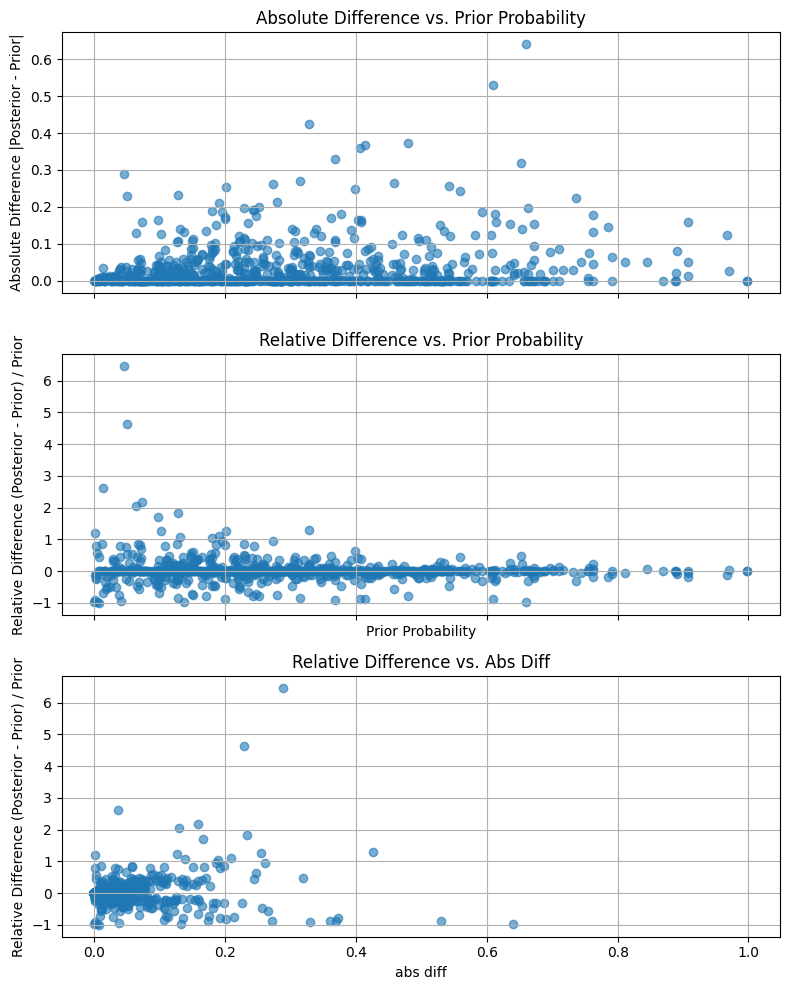

In [71]:
import matplotlib.pyplot as plt
import numpy as np

prior = full_df["prior_probability"].astype(float)
posterior = full_df["probability"].astype(float)

# Mask out rows where prior or posterior is NaN
mask = ~(prior.isna() | posterior.isna())
prior = prior[mask]
posterior = posterior[mask]

abs_diff = np.abs(posterior - prior)
# Avoid division by zero; mask entries where prior=0 for rel_diff
with np.errstate(divide='ignore', invalid='ignore'):
    rel_diff = np.where(prior != 0, (posterior - prior) / prior, np.nan)

fig, axs = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

# Absolute difference plot
axs[0].scatter(prior, abs_diff, alpha=0.6)
axs[0].set_ylabel("Absolute Difference |Posterior - Prior|")
axs[0].set_title("Absolute Difference vs. Prior Probability")
axs[0].grid(True)

# Relative difference plot
axs[1].scatter(prior, rel_diff, alpha=0.6)
axs[1].set_xlabel("Prior Probability")
axs[1].set_ylabel("Relative Difference (Posterior - Prior) / Prior")
axs[1].set_title("Relative Difference vs. Prior Probability")
axs[1].grid(True)


axs[2].scatter(abs_diff, rel_diff, alpha=0.6)
axs[2].set_xlabel("abs diff")
axs[2].set_ylabel("Relative Difference (Posterior - Prior) / Prior")
axs[2].set_title("Relative Difference vs. Abs Diff")
axs[2].grid(True)


plt.tight_layout()
plt.show()


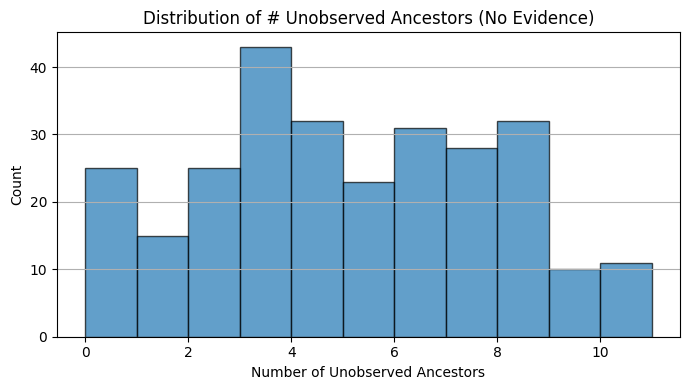

In [72]:

# "No evidence" -> evidence set is empty; so filter rows with len(evidence)==0
mask_no_evidence = full_df['num_evidence'] == 0

no_evidence_df = full_df[mask_no_evidence]

unobs_anc_counts = no_evidence_df["num_unobserved_ancestors"]

plt.figure(figsize=(7, 4))
plt.hist(unobs_anc_counts, bins=range(int(unobs_anc_counts.min()), int(unobs_anc_counts.max())+2), edgecolor="black", alpha=0.7)
plt.title("Distribution of # Unobserved Ancestors (No Evidence)")
plt.xlabel("Number of Unobserved Ancestors")
plt.ylabel("Count")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

In [73]:
# Keep only queries where relative difference > 1 and absolute difference > 0.1
# Store them for further analysis
full_df = full_df.copy()
full_df["abs_diff"] = abs_diff
full_df["rel_diff"] = rel_diff

full_df = full_df[(full_df["rel_diff"] > 1) & (full_df["abs_diff"] > 0.1)].reset_index(drop=True)

# Keep only queries with at least 3 unobserved ancestors
full_df = full_df[full_df["num_unobserved_ancestors"] >= 3].reset_index(drop=True)



In [ ]:
full_df

,n,target_tw,achieved_tw,naming,arity,alpha,determinism,seed,variant_index,num_edges,...,query_vars,query_states,evidence,distance,num_evidence,probability,prior_probability,num_unobserved_ancestors,abs_diff,rel_diff
0,9,5,5,confusing,range:2-3,0.5,0.0,45,0,23,...,"[np.str_('M_clcji8'), np.str_('K_gvnrp2')]","['s2', 's0']","{np.str_('A_iqeo85'): 's1', np.str_('K_5si3ik'...",1,2,0.227407,0.101151,5,0.126256,1.248195
1,9,7,7,confusing,range:2-3,0.5,0.0,10020,1,34,...,"[np.str_('A_qw4mqw'), np.str_('Y_cimb2b')]","['s0', 's2']","{np.str_('L_ci65w8'): 's0', np.str_('D_rqczac'...",1,2,0.231093,0.072795,4,0.158298,2.174567
2,9,7,7,confusing,range:2-3,0.5,0.0,29966,3,34,...,"[np.str_('Y_q2xqrf'), np.str_('F_tsl31q')]","['s0', 's1']","{np.str_('L_ci65w8'): 's1', np.str_('D_5f595g'...",1,2,0.332533,0.044623,3,0.287910,6.452023
3,9,7,7,confusing,range:2-3,0.5,0.0,29966,3,34,...,"[np.str_('P_48cwxi'), np.str_('G_ash0j4')]","['s0', 's1']","{np.str_('Y_q2xqrf'): 's1', np.str_('L_ci65w8'...",1,2,0.753816,0.328371,3,0.425445,1.295621
4,11,5,5,confusing,range:2-3,1.0,0.0,50,0,24,...,"[np.str_('F_gwfc5h'), np.str_('B_j3x6tf')]","['s0', 's2']",{np.str_('Q_6l74eg'): 's0'},1,1,0.359930,0.127159,6,0.232771,1.830559
5,11,5,5,confusing,range:2-3,0.5,0.0,51,0,24,...,"[np.str_('G_buoewt'), np.str_('F_gwfc5h')]","['s1', 's0']","{np.str_('A_49125p'): 's1', np.str_('Q_6l74eg'...",1,2,0.399759,0.190164,7,0.209595,1.102180
6,11,5,5,confusing,range:2-3,0.5,0.0,51,0,24,...,[np.str_('A_49125p')],['s0'],"{np.str_('Q_6l74eg'): 's1', np.str_('C_p490cm'...",2,2,0.456542,0.201700,7,0.254842,1.263466
7,11,7,6,confusing,range:2-3,0.5,0.0,53,0,34,...,"[np.str_('V_muljqw'), np.str_('F_nhuh63')]","['s1', 's1']",{np.str_('G_zwp5v0'): 's0'},1,1,0.192638,0.062860,9,0.129778,2.064572
8,11,7,6,confusing,range:2-3,0.5,0.0,53,0,34,...,"[np.str_('A_04jxrk'), np.str_('X_m2d46j')]","['s1', 's1']","{np.str_('W_zz5knb'): 's1', np.str_('X_6fl199'...",1,2,0.278748,0.049450,5,0.229298,4.637005
9,11,7,6,confusing,range:2-3,0.5,0.0,53,0,34,...,"[np.str_('W_zz5knb'), np.str_('X_m2d46j')]","['s0', 's0']",{np.str_('A_04jxrk'): 's1'},1,1,0.269816,0.130899,6,0.138918,1.061258


In [75]:
# Choose a row index from full_df to analyze
test_row_index = 0  # Change this to any valid row index

print("=" * 80)
print(f"TESTING QUERY-SPECIFIC COMPLEXITY COMPUTATION FOR ROW {test_row_index}")
print("=" * 80)

# Compute complexity for the selected row
complexity_result = compute_query_complexity(full_df, all_bayesian_networks, test_row_index, verbose=True)

print("\n" + "=" * 80)
print("DETAILED COMPLEXITY METRICS:")
print("=" * 80)

# Display the results in a nice format
for key, value in complexity_result.items():
    if key not in ['elimination_order', 'complete_elimination_order', 'factor_sizes', 'query_vars', 'query_states', 'evidence', 'keep_vars', 'eliminate_vars']:
        print(f"{key:25}: {value}")
    elif key in ['elimination_order', 'complete_elimination_order']:
        print(f"{key:25}: {value[:5]}... (showing first 5 of {len(value)})")
    elif key == 'factor_sizes':
        print(f"{key:25}: {value[:5]}... (showing first 5 of {len(value)})")
    else:
        print(f"{key:25}: {value}")

print("\n" + "=" * 80)
print("FACTOR SIZE PROGRESSION:")
print("=" * 80)
for i, size in enumerate(complexity_result['factor_sizes']):
    print(f"Step {i+1:2d}: {size:8,} entries")

print("\n" + "=" * 80)
print("QUERY-SPECIFIC ANALYSIS:")
print("=" * 80)
print(f"Query variables kept: {complexity_result['keep_vars']}")
print(f"Variables eliminated: {complexity_result['eliminate_vars']}")
print(f"Variables eliminated: {complexity_result['num_eliminated_vars']}/{complexity_result['num_vars']} ({complexity_result['num_eliminated_vars']/complexity_result['num_vars']*100:.1f}%)")


TESTING QUERY-SPECIFIC COMPLEXITY COMPUTATION FOR ROW 0
Computing complexity for query: P(['M_clcji8', 'K_gvnrp2']=['s2', 's0'] | {'A_iqeo85': 's1', 'K_5si3ik': 's2'})
BN: 4, Query: 23
Variable cardinalities: defaultdict(<class 'int'>, {'U_9d6udx': np.int64(3), 'X_wzdhd9': np.int64(3), 'G_bo3vt6': np.int64(3), 'K_5si3ik': np.int64(3), 'I_rk69zv': np.int64(3), 'W_qis23b': np.int64(3), 'M_clcji8': np.int64(3), 'K_gvnrp2': np.int64(3), 'A_iqeo85': np.int64(3)})
Variables to keep (query): ['K_gvnrp2', 'M_clcji8']
Variables to eliminate: ['A_iqeo85', 'G_bo3vt6', 'I_rk69zv', 'K_5si3ik', 'U_9d6udx', 'W_qis23b', 'X_wzdhd9']
Evidence variables: ['A_iqeo85', 'K_5si3ik']
Effective cardinalities (after evidence): {'U_9d6udx': np.int64(3), 'X_wzdhd9': np.int64(3), 'G_bo3vt6': np.int64(3), 'K_5si3ik': 1, 'I_rk69zv': np.int64(3), 'W_qis23b': np.int64(3), 'M_clcji8': np.int64(3), 'K_gvnrp2': np.int64(3), 'A_iqeo85': 1}


  0%|          | 0/7 [00:00<?, ?it/s]

Elimination order (variables to eliminate): ['I_rk69zv', 'A_iqeo85', 'W_qis23b', 'G_bo3vt6', 'K_5si3ik', 'X_wzdhd9', 'U_9d6udx']
Complete elimination order: ['I_rk69zv', 'A_iqeo85', 'W_qis23b', 'G_bo3vt6', 'K_5si3ik', 'X_wzdhd9', 'U_9d6udx', 'M_clcji8', 'K_gvnrp2']
Induced width: 6
Step 1: Eliminating I_rk69zv, neighbors: ['A_iqeo85', 'X_wzdhd9', 'K_5si3ik', 'M_clcji8', 'G_bo3vt6', 'W_qis23b'], factor size: 243
Step 2: Eliminating A_iqeo85, neighbors: ['M_clcji8', 'X_wzdhd9', 'G_bo3vt6', 'K_5si3ik', 'W_qis23b'], factor size: 81
Step 3: Eliminating W_qis23b, neighbors: ['U_9d6udx', 'M_clcji8', 'X_wzdhd9', 'G_bo3vt6', 'K_5si3ik'], factor size: 243
Step 4: Eliminating G_bo3vt6, neighbors: ['U_9d6udx', 'M_clcji8', 'X_wzdhd9', 'K_gvnrp2', 'K_5si3ik'], factor size: 243
Step 5: Eliminating K_5si3ik, neighbors: ['U_9d6udx', 'M_clcji8', 'X_wzdhd9', 'K_gvnrp2'], factor size: 81
Step 6: Eliminating X_wzdhd9, neighbors: ['U_9d6udx', 'M_clcji8', 'K_gvnrp2'], factor size: 81
Step 7: Eliminating U_9d

In [76]:
complexity_df = compute_all_query_complexities(full_df, all_bayesian_networks, verbose=True)
print("\nComplexity DataFrame:")
display(complexity_df.head())

Processing query 1/11...


  0%|          | 0/7 [00:00<?, ?it/s]

Processing query 2/11...


  0%|          | 0/7 [00:00<?, ?it/s]

Processing query 3/11...


  0%|          | 0/7 [00:00<?, ?it/s]

Processing query 4/11...


  0%|          | 0/7 [00:00<?, ?it/s]

Processing query 5/11...


  0%|          | 0/9 [00:00<?, ?it/s]

Processing query 6/11...


  0%|          | 0/9 [00:00<?, ?it/s]

Processing query 7/11...


  0%|          | 0/10 [00:00<?, ?it/s]

Processing query 8/11...


  0%|          | 0/9 [00:00<?, ?it/s]

Processing query 9/11...


  0%|          | 0/9 [00:00<?, ?it/s]

Processing query 10/11...


  0%|          | 0/9 [00:00<?, ?it/s]

Processing query 11/11...


  0%|          | 0/9 [00:00<?, ?it/s]


Computed complexity for 11 queries
Successful computations: 11
Failed computations: 0

Complexity DataFrame:


,row_index,bn_index,query_index,query_vars,query_states,evidence,num_vars,num_edges,num_query_vars,num_evidence_vars,...,complete_elimination_order,induced_width,total_cost,max_factor_size,avg_factor_size,factor_sizes,log_total_cost,log_max_factor_size,keep_vars,eliminate_vars
0,0,4,23,"[M_clcji8, K_gvnrp2]","[s2, s0]","{'A_iqeo85': 's1', 'K_5si3ik': 's2'}",9,23,2,2,...,"[I_rk69zv, A_iqeo85, W_qis23b, G_bo3vt6, K_5si...",6,1008,243,144.000000,"[243, 81, 243, 243, 81, 81, 27]",9.977280,7.924813,"[K_gvnrp2, M_clcji8]","[A_iqeo85, G_bo3vt6, I_rk69zv, K_5si3ik, U_9d6..."
1,1,13,18,"[A_qw4mqw, Y_cimb2b]","[s0, s2]","{'L_ci65w8': 's0', 'D_rqczac': 's2'}",9,34,2,2,...,"[D_rqczac, L_ci65w8, F_tsl31q, D_5f595g, G_ash...",7,951,288,135.857143,"[96, 288, 288, 144, 72, 36, 18]",9.893302,8.169925,"[A_qw4mqw, Y_cimb2b]","[D_5f595g, D_rqczac, F_tsl31q, G_ash0j4, L_ci6..."
2,2,15,10,"[Y_q2xqrf, F_tsl31q]","[s0, s1]","{'L_ci65w8': 's1', 'D_5f595g': 's1'}",9,34,2,2,...,"[D_rqczac, L_ci65w8, G_ash0j4, Y_cimb2b, P_48c...",7,390,96,55.714286,"[96, 96, 96, 48, 24, 12, 12]",8.607330,6.584963,"[F_tsl31q, Y_q2xqrf]","[A_qw4mqw, D_5f595g, D_rqczac, G_ash0j4, L_ci6..."
3,3,15,15,"[P_48cwxi, G_ash0j4]","[s0, s1]","{'Y_q2xqrf': 's1', 'L_ci65w8': 's0'}",9,34,2,2,...,"[D_rqczac, F_tsl31q, L_ci65w8, D_5f595g, Y_cim...",7,292,96,41.714286,"[96, 96, 32, 32, 16, 8, 8]",8.189825,6.584963,"[G_ash0j4, P_48cwxi]","[A_qw4mqw, D_5f595g, D_rqczac, F_tsl31q, L_ci6..."
4,4,16,4,"[F_gwfc5h, B_j3x6tf]","[s0, s2]",{'Q_6l74eg': 's0'},11,24,2,1,...,"[C_p490cm, A_49125p, A_l40h2y, P_eo9210, A_dck...",6,738,216,82.000000,"[36, 162, 54, 216, 72, 108, 36, 36, 12]",9.527477,7.754888,"[B_j3x6tf, F_gwfc5h]","[A_49125p, A_dcka33, A_l40h2y, C_p490cm, G_buo..."


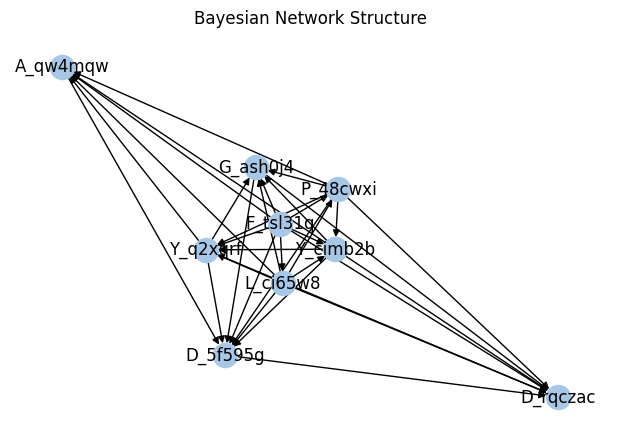

Query: P(P_48cwxi=s0, G_ash0j4=s1 | Y_q2xqrf=s1, L_ci65w8=s0)
Exact probability: 0.7538155929373456

SYSTEM PROMPT:
You are an assistant that helps with probability reasoning calculations. You will be given some conditional probability tables (CPTs) and a query.

## CPT Format Guide

### 1. Marginal CPTs (nodes with no parents)
```
+----------------+------------+
| Node(Value)    | Probability|
+----------------+------------+
| A(yes)         | 0.3        |
+----------------+------------+
| A(no)          | 0.7        |
+----------------+------------+
```
Each row means **P(Node=Value) = Probability**.

### 2. Conditional CPTs (nodes with one or more parents)
- The **first rows** list all parent nodes
- Each **column** represents one combination of parent values
- **Child rows** give P(child=value | parent assignment) for that column
- Probabilities in each column **sum to 1**

**Example:**
```
+----------+----------+----------+----------+----------+
| A        | A(yes)   | A(yes)   | 

INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


KeyboardInterrupt: 

In [77]:
# Inspect a single row: draw BN, call LLM, compare\n
from bn_query_sweep import inspect_row_and_call_llm, call_llm_for_query
from pathlib import Path
ENABLE_LLM_CALLS = False
if ENABLE_LLM_CALLS:
    # Choose a row index from full_df
    #row_index = 330
    row_index = 3

    result = inspect_row_and_call_llm(
        full_df=full_df,
        all_bayesian_networks=all_bayesian_networks,
        row_index=row_index,
        openai_client=client,
        model=MODEL,
        prompts_path=prompt_path,
        draw_kwargs={"figsize": (6, 4)},
    )
    print(result)

In [ ]:
# Optional: Call LLM on a subset AFTER query generation
# Provide indices of rows in full_df for which to call the LLM.
# Import _parse_field from bn_query_sweep instead of defining it locally
from bn_query_sweep import _parse_field

# Ensure LLM columns exist
if 'llm_probability' not in full_df.columns:
    full_df['llm_probability'] = None
if 'llm_response' not in full_df.columns:
    full_df['llm_response'] = None

ENABLE_LLM_CALLS = True
if ENABLE_LLM_CALLS:
    # Select which rows to send to LLM (example below commented out)
    #selected_indices = list(full_df.sample(n=40, random_state=0).index)
    selected_indices = list(full_df.sample(n=2, random_state=0).index)
    #selected_indices = list(full_df.index)

    for ridx in selected_indices:
        row = full_df.iloc[ridx]
        bn = all_bayesian_networks[int(row['bn_index'])]['bn']
        query_vars = _parse_field(row['query_vars']) or []
        query_states = _parse_field(row['query_states']) or []
        evidence = _parse_field(row['evidence']) or None
        print(f"Processing BN {int(row['bn_index'])}/{len(all_bayesian_networks)}, Query {int(row['query_index'])}...")
        llm_prob, llm_response = call_llm_for_query(bn, query_vars, query_states, evidence)
        full_df.at[ridx, 'llm_probability'] = llm_prob
        full_df.at[ridx, 'llm_response'] = llm_response
else:
    print("LLM calls are disabled. Skipping batch LLM processing.")
    print(f"Would have processed {len(full_df)} queries if LLM calls were enabled.")

ENABLE_LLM_CALLS = False

In [ ]:
out_llm_csv = out_query_csv.with_name(out_query_csv.stem + "_with_llm.csv")
# Save the DataFrame with LLM responses to a CSV file
#out_llm_csv = out_query_csv.replace(".csv", "_with_llm.csv")
full_df.to_csv(out_llm_csv, index=False)
print("Saved DataFrame with LLM responses to", out_llm_csv)

In [ ]:
# Print rows with non-empty llm_probability
llm_rows = full_df[full_df['llm_probability'].notna()]
print(f"Found {len(llm_rows)} rows with LLM probability values:")
print("=" * 80)
display(llm_rows)


In [ ]:
# Display LLM performance statistics
print("LLM Performance Analysis:")
print("=" * 50)

# Count successful LLM responses
successful_llm = full_df['llm_probability'].notna().sum()
total_queries = len(full_df)
print(f"Successful LLM responses: {successful_llm}/{total_queries} ({successful_llm/total_queries*100:.1f}%)")

# Save enhanced results with LLM data
enhanced_csv = repo_root / 'notebooks' / 'graph_generation' / 'bn_generation_sweep_queries_with_llm.csv'
full_df.to_csv(enhanced_csv, index=False)
print(f'Saved enhanced results with LLM data to {enhanced_csv}')

In [ ]:
# Calculate accuracy metrics for successful responses
if successful_llm > 0:
    # Filter to only successful LLM responses
    successful_df = full_df[full_df['llm_probability'].notna() & full_df['probability'].notna()]
    
    if len(successful_df) > 0:
        # Calculate absolute errors
        successful_df = successful_df.copy()
        successful_df['abs_error'] = abs(successful_df['llm_probability'] - successful_df['probability'])
        successful_df['rel_error'] = successful_df['abs_error'] / successful_df['probability']
        
        print(f"\nAccuracy Metrics (for {len(successful_df)} successful responses):")
        print(f"Mean Absolute Error: {successful_df['abs_error'].mean():.6f}")
        print(f"Mean Relative Error: {successful_df['rel_error'].mean():.6f}")
        print(f"Max Absolute Error: {successful_df['abs_error'].max():.6f}")
        print(f"Max Relative Error: {successful_df['rel_error'].max():.6f}")
        
        # Show some examples
        print(f"\nFirst 5 successful responses:")
        display(successful_df[['query_vars', 'query_states', 'evidence', 'probability', 'llm_probability', 'abs_error']].head())
    else:
        print("No successful LLM responses with exact inference results to compare.")
else:
    print("No successful LLM responses.")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Filter to only successful LLM responses with exact inference results
plot_df = full_df[full_df['llm_probability'].notna() & full_df['probability'].notna()].copy()
plot_df['abs_error'] = abs(plot_df['llm_probability'] - plot_df['probability'])

if len(plot_df) > 0:
    # Identify all BN and query property columns (exclude result columns)
    exclude_cols = {'bn_index', 'query_vars', 'query_states', 'evidence', 'probability', 
                   'llm_probability', 'llm_response', 'abs_error', 'rel_error', 'target_tw', 'n', 'seed', 'variant_index',
                   'alpha', 'determinism', 'arity', 'query_index', 
                   'achieved_tw', 'num_nodes'}
    
    # Get all columns that are BN or query properties
    property_cols = [col for col in full_df.columns if col not in exclude_cols]
    
    # Calculate number of subplots needed
    n_props = len(property_cols)
    n_cols = min(4, n_props)  # Max 4 columns
    n_rows = (n_props + n_cols - 1) // n_cols  # Ceiling division
    
    # Create figure with subplots for all properties
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
    fig.suptitle('Absolute Error by BN and Query Properties', fontsize=16, fontweight='bold')
    
    # Flatten axes for easier indexing
    if n_props == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()
    
    # Create boxplots for each property
    for i, prop in enumerate(property_cols):
        ax = axes[i]
        
        # Get unique values for this property
        unique_vals = sorted(plot_df[prop].unique())
        
        # Create boxplot data
        box_data = []
        labels = []
        
        for val in unique_vals:
            subset = plot_df[plot_df[prop] == val]['abs_error']
            if len(subset) > 0:  # Only include if there's data
                box_data.append(subset.values)
                labels.append(str(val))
        
        if box_data:  # Only plot if we have data
            ax.boxplot(box_data, labels=labels)
            ax.set_title(f'Absolute Error by {prop.replace("_", " ").title()}')
            ax.set_xlabel(prop.replace("_", " ").title())
            ax.set_ylabel('Absolute Error')
            ax.grid(True, alpha=0.3)
            
            # Rotate x-axis labels if there are many unique values
            if len(labels) > 5:
                ax.tick_params(axis='x', rotation=45)
    
    # Hide unused subplots
    for i in range(n_props, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics for each property
    print("\nSummary Statistics by Property:")
    print("=" * 50)
    
    for prop in property_cols:
        print(f"\n{prop.upper()}:")
        prop_stats = plot_df.groupby(prop)['abs_error'].agg(['count', 'mean', 'std', 'min', 'max'])
        print(prop_stats.round(6))
        
else:
    print("No successful LLM responses with exact inference results available for plotting.")


In [ ]:
def compute_all_query_complexities(full_df, all_bayesian_networks, verbose=False):
    """
    Compute complexity metrics for all queries in full_df.
    
    Parameters:
    - full_df: DataFrame containing query information
    - all_bayesian_networks: List of BN dictionaries with 'bn' and 'meta' keys
    - verbose: If True, print progress information
    
    Returns:
    - pd.DataFrame: DataFrame with complexity metrics for each query
    """
    complexity_results = []
    
    for idx in range(len(full_df)):
        if verbose:
            print(f"Processing query {idx+1}/{len(full_df)}...")
        
        try:
            result = compute_query_complexity(full_df, all_bayesian_networks, idx, verbose=False)
            complexity_results.append(result)
        except Exception as e:
            print(f"Error processing row {idx}: {e}")
            # Add a row with error information
            complexity_results.append({
                'row_index': idx,
                'error': str(e),
                'induced_width': None,
                'total_cost': None,
                'max_factor_size': None,
            })
    
    # Convert to DataFrame
    complexity_df = pd.DataFrame(complexity_results)
    
    if verbose:
        print(f"\nComputed complexity for {len(complexity_results)} queries")
        if 'error' in complexity_df.columns:
            successful = len(complexity_df[complexity_df['error'].isna()])
            failed = len(complexity_df[complexity_df['error'].notna()])
        else:
            successful = len(complexity_df)
            failed = 0
        print(f"Successful computations: {successful}")
        print(f"Failed computations: {failed}")
    
    return complexity_df


